Example notebook showing how to use the MCMC sampler (currently in development)

In [1]:
import os
import sys
import argparse
import torch
from getdist import plots, MCSamples
import getdist
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [2]:
path = os.path.realpath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, path)

In [3]:
from nnest import MCMCSampler

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
# Himmelblau
dims = 2
def loglike(z):
    z1 = z[:, 0]
    z2 = z[:, 1]
    return - (z1**2 + z2 - 11.)**2 - (z1 + z2**2 - 7.)**2

In [6]:
# Rosenbrock
#dims = 2
#def loglike(z):
#    return np.array([-sum(100.0 * (x[1:] - x[:-1] ** 2.0) ** 2.0 + (1 - x[:-1]) ** 2.0) for x in z])

In [7]:
# Gauss
#corr = 0.99
#dims = 2
#def loglike(x):
#    return multivariate_normal.logpdf(x, mean=np.zeros(dims), cov=np.eye(dims) + corr * (1 - np.eye(dims)))

In [8]:
# Eggbox
#dims = 2
#def loglike(x):
#    chi = (np.cos(x[:,0] / 2.))*(np.cos(x[:,1] / 2.))
#    return (2. + chi)**5

In [9]:
sampler = MCMCSampler(dims, loglike, flow='spline')

Creating directory for new run logs/test/run53
[nnest.trainer] [INFO] SingleSpeedSpline(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): ActNorm()
      (1): Invertible1x1Conv()
      (2): NSF_CL(
        (f1): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): LeakyReLU(negative_slope=0.2)
            (6): Linear(in_features=16, out_features=23, bias=True)
          )
        )
        (f2): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_fe

In [10]:
init_samples = sampler._init_samples(init_scale=8.0, mcmc_steps=100)

[nnest.sampler] [INFO] Getting initial samples with emcee
[nnest.sampler] [INFO] Mean acceptance fraction: [0.088]


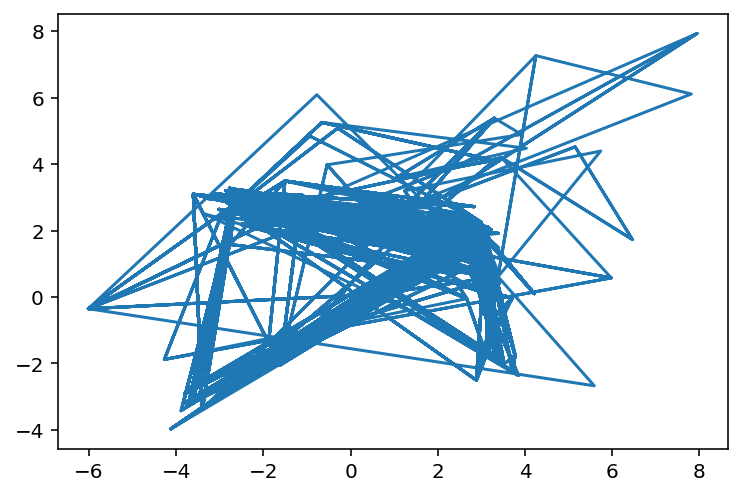

In [11]:
plt.plot(init_samples[:,0], init_samples[:,1])
plt.show()

In [ ]:
sampler.run(bootstrap_iters=2, jitter=0.01, init_samples=init_samples)

[nnest.sampler] [INFO] Alpha [0.7071]
[nnest.sampler] [INFO] Bootstrap step [1]
[nnest.trainer] [INFO] Number of training samples [2000]
[nnest.trainer] [INFO] Training jitter [0.0100]
[nnest.trainer] [INFO] Epoch [1] train loss [0.0293] validation loss [0.0137]
[nnest.trainer] [INFO] Epoch [50] train loss [0.0023] validation loss [0.0003]
[nnest.trainer] [INFO] Epoch [100] train loss [0.0005] validation loss [-0.0005]
[nnest.trainer] [INFO] Epoch [150] train loss [-0.0006] validation loss [-0.0011]
[nnest.trainer] [INFO] Epoch [200] train loss [-0.0013] validation loss [-0.0015]
[nnest.trainer] [INFO] Best epoch [200] validation loss [-0.0015]
[nnest.sampler] [INFO] Bootstrap step [2]
[nnest.sampler] [INFO] Acceptance [0.0000] min ESS [0.9365] max ESS [0.9650] average jump distance [0.0000]
[nnest.sampler] [INFO] Acceptance [0.2637] min ESS [2.6493] max ESS [4.1688] average jump distance [0.1278]
[nnest.sampler] [INFO] Acceptance [0.2419] min ESS [3.4404] max ESS [3.6361] average jump

In [13]:
samples = [sampler.samples[i, :, :].squeeze() for i in range(sampler.samples.shape[0])]
latent_samples = [sampler.latent_samples[i, :, :].squeeze() for i in range(sampler.latent_samples.shape[0])]
loglikes = [sampler.loglikes[i, :].squeeze() for i in range(sampler.loglikes.shape[0])]

In [14]:
mc = MCSamples(samples=samples, loglikes=loglikes)

Removed no burn in


In [15]:
print(mc.getEffectiveSamples())
print(mc.getMargeStats())
print(mc.getConvergeTests())

820.840837035614
Marginalized limits: 0.68; 0.95; 0.99

parameter   mean           sddev          lower1         upper1         limit1 lower2         upper2         limit2 lower3         upper3         limit3 
param1      9.9899845E-01  7.2602253E-01  4.7657804E-01  1.9390859E+00  two   -4.2539592E-01  2.2003885E+00  two   -7.7555894E-01  2.3345258E+00  two     p_{1}
param2      1.5172915E+00  1.3578765E+00 -1.1046900E-01  2.5237766E+00  two   -1.4685800E-01  4.3717976E+00  two   -2.0166148E-01  4.8192898E+00  two     p_{2}

Parameter autocorrelation lengths (effective number of samples N_eff = tot weight/weight length)

            Weight Length   Sample length           N_eff
param1           2.99E+01           29.86             837
param2           3.50E+01           35.00             714


mean convergence stats using remaining chains
param sqrt(var(chain mean)/mean(chain var))

param1        0.0695  p_{1}
param2        0.0410  p_{2}

var(mean)/mean(var) for eigenvalues of covarian

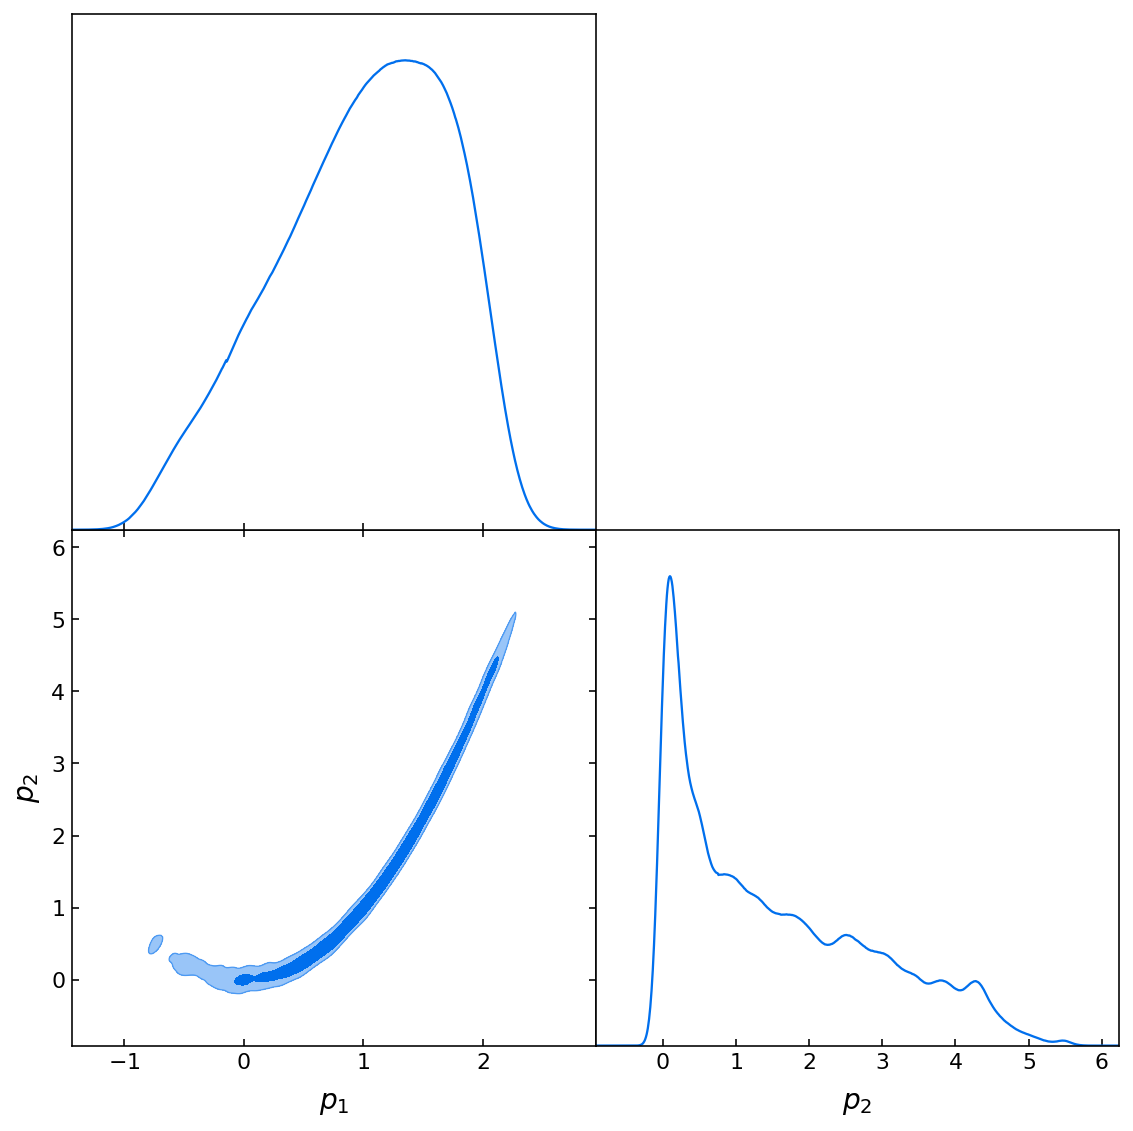

In [16]:
g = plots.getSubplotPlotter(width_inch=8)
g.triangle_plot(mc, filled=True)

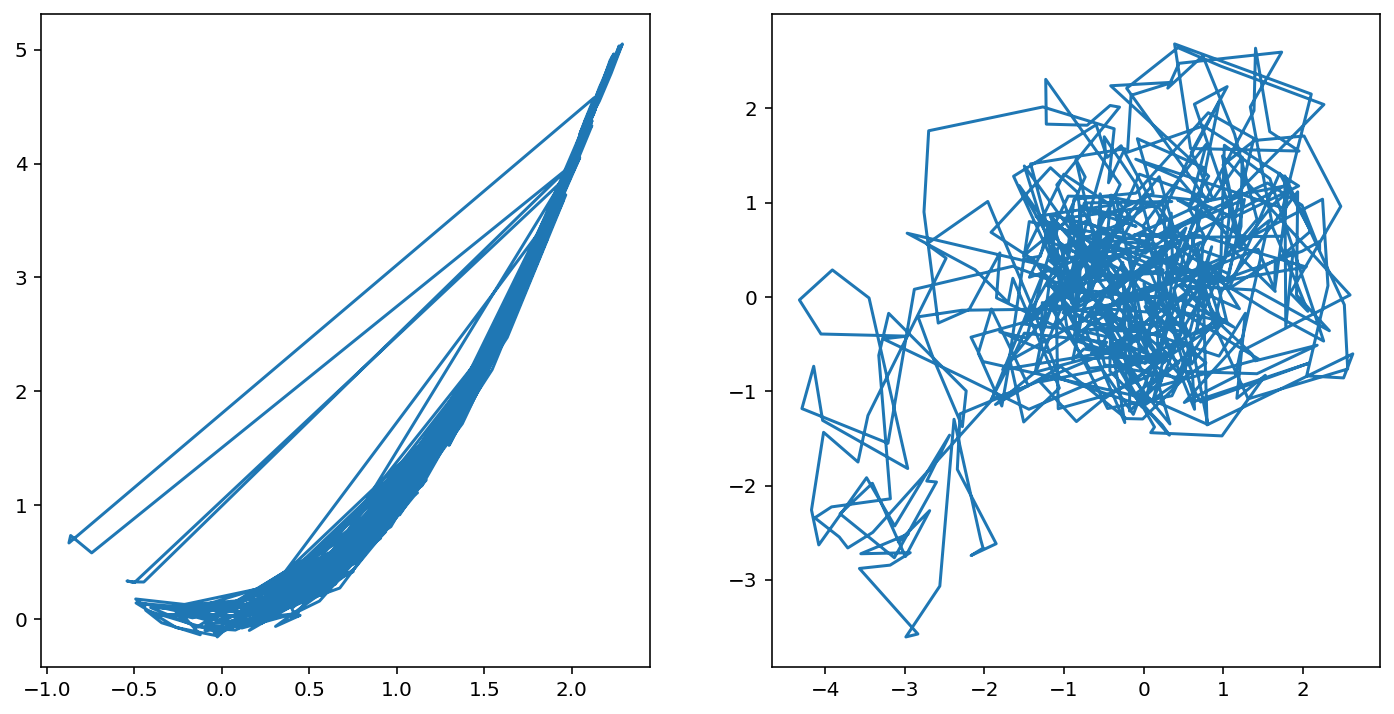

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(samples[0][0:1000,0], samples[0][0:1000,1])
ax[1].plot(latent_samples[0][0:1000,0], latent_samples[0][0:1000,1])
plt.show()